In [192]:
#league rules!
numberOfTeams = 10

isFlex = True

ppr = .5
rushYards = .1
receivingYards = .1
rushTD = 6
receivingTD = 6
passYards = 1/25
passTD = 4
fmb = -2
int = -2

In [150]:
import pandas as pd, numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy.stats import norm
from joblib import dump

In [231]:
combo2 = pd.read_csv("../data/2023_model_data_0_PPR.csv")
modelData = combo2.drop(columns=["Name", "Unnamed: 0", "team.y", "position.y", "position.x", "team.x", "nextSeasonsTeam", "gsis_id", "team", "name rank", "gsis_id", "team.y", "position.y", "X4", "X5", "X6", "X7", "X8", "firstFullYear"])

In [232]:
s = set(combo2[combo2['year'] == 2023]['team'])
one_line_output_with_quotes = ', '.join([f"'{str(item)}'" for item in s])
one_line_output_with_quotes

"'NO', 'ARI', 'TEN', 'DET', 'WAS', 'BUF', 'ATL', 'NYJ', 'SF', 'TB', 'CLE', 'MIN', 'PHI', 'LV', 'HOU', 'CIN', 'MIA', 'LAC', 'NE', 'PIT', 'IND', 'BAL', 'DAL', 'DEN', 'KC', 'NYG', 'SEA', 'GB', 'JAC', 'CHI', 'CAR', 'LAR'"

In [233]:
#label encoding
label_encoders = {}
for column in modelData.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    modelData[column] = le.fit_transform(modelData[column])
    label_encoders[column] = le

In [234]:
season = 2023
train = modelData[modelData["year"] < season]
test = modelData[modelData["year"] == season]
c2_whole = combo2[combo2["year"] == season]
names = c2_whole['Name'].reset_index(drop=True)
positions = c2_whole['position'].reset_index(drop=True)
teams = c2_whole['team']

In [235]:
#data
train_y = train["nextSeasonPAR"]
train_x = train.drop(columns = "nextSeasonPAR", axis = 1)
test_y = test["nextSeasonPAR"]
test_x = test.drop(columns = "nextSeasonPAR", axis = 1)

In [236]:
#train it
ntrees = 500
rf = RandomForestRegressor(n_estimators=ntrees)
rf.fit(train_x, train_y)

RandomForestRegressor(n_estimators=500)

In [103]:
#FOR SAVING MODEL FOR CALIBRATION
# dump(rf, f"models/{season}_rf_{ntrees}tree.joblib")
# test_x.to_csv(f"data/test_x_{season}.csv", index=False)
# test_y.to_csv(f"data/test_y_{season}.csv", index=False)
# c2_whole.to_csv(f"data/c2_whole_{season}.csv", index=False)

In [237]:
#residuals plot
preds = rf.predict(test_x)

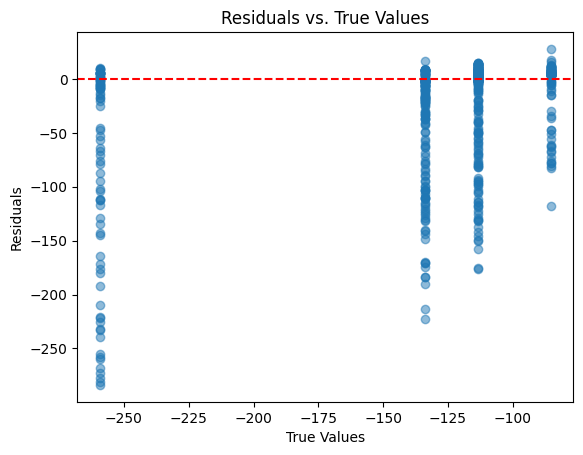

In [238]:
residuals = test_y - preds

# Plot residuals
plt.scatter(test_y, residuals, alpha=0.5)
plt.title('Residuals vs. True Values')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [239]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(test_y, preds)
mse = mean_squared_error(test_y, preds)
r2 = r2_score(test_y, rf.predict(test_x))

print(f"MAE: {mae}, MSE: {mse}, R^2: {r2}")

MAE: 37.43218885993483, MSE: 4569.914452194234, R^2: -0.6230947793001769


In [240]:
#prediction distributions
# Get predictions from each tree in the RandomForestRegressor
tree_predictions = []

for tree in rf.estimators_:
    tree_predictions.append(tree.predict(test_x))

# Convert the predictions to a DataFrame
tree_predictions_df = pd.DataFrame(tree_predictions).transpose()
tree_predictions_df.columns = [f"Tree_{i+1}" for i in range(rf.n_estimators)]

# Display the first few rows of the tree predictions DataFrame
tree_predictions_df.head()

/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X 

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_491,Tree_492,Tree_493,Tree_494,Tree_495,Tree_496,Tree_497,Tree_498,Tree_499,Tree_500
0,129.26,-2.00,-123.1,57.50,159.00,-55.84,159.00,44.76,14.50,30.44,...,129.26,26.04,58.32,69.60,-30.46,-2.26,-41.20,48.60,159.00,21.06
1,123.04,19.80,195.0,14.50,-31.90,-66.80,155.50,-3.30,49.96,-105.30,...,132.00,-125.10,0.00,85.60,123.04,-3.30,-14.80,-14.74,49.96,-4.56
2,78.94,-2.00,-123.1,24.10,-20.20,132.00,-126.80,-3.30,-14.74,-18.82,...,132.00,26.04,58.32,52.60,123.04,-55.84,-14.74,24.10,14.50,-35.90
3,-134.10,56.90,94.9,11.60,36.30,62.44,89.24,-3.30,14.50,14.66,...,0.00,-41.20,43.20,-1.58,16.40,42.10,-1.58,-2.58,14.50,-2.26
4,57.32,32.44,32.9,9.12,92.34,-257.34,48.96,20.80,0.26,10.58,...,-118.60,32.44,-128.68,-145.26,-6.66,90.52,9.46,-37.54,-54.78,-59.96


In [241]:
#include more details in pred dataframe
tree_predictions_df['name'] = names
tree_predictions_df['preds'] = preds
tree_predictions_df['pos'] = positions

tree_predictions_df

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_494,Tree_495,Tree_496,Tree_497,Tree_498,Tree_499,Tree_500,name,preds,pos
0,129.26,-2.00,-123.10,57.50,159.00,-55.84,159.00,44.76,14.50,30.44,...,69.60,-30.46,-2.26,-41.20,48.60,159.00,21.06,JoshAllen,13.92964,QB
1,123.04,19.80,195.00,14.50,-31.90,-66.80,155.50,-3.30,49.96,-105.30,...,85.60,123.04,-3.30,-14.80,-14.74,49.96,-4.56,PatrickMahomes,18.48192,QB
2,78.94,-2.00,-123.10,24.10,-20.20,132.00,-126.80,-3.30,-14.74,-18.82,...,52.60,123.04,-55.84,-14.74,24.10,14.50,-35.90,JalenHurts,24.53300,QB
3,-134.10,56.90,94.90,11.60,36.30,62.44,89.24,-3.30,14.50,14.66,...,-1.58,16.40,42.10,-1.58,-2.58,14.50,-2.26,JoeBurrow,21.92432,QB
4,57.32,32.44,32.90,9.12,92.34,-257.34,48.96,20.80,0.26,10.58,...,-145.26,-6.66,90.52,9.46,-37.54,-54.78,-59.96,GenoSmith,-33.88216,QB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,-125.90,-119.10,-115.80,-123.50,-125.90,-119.10,-125.90,-130.90,-119.10,-119.10,...,-117.60,-125.90,-129.12,-119.10,-119.10,-119.00,-119.10,IhmirSmithMarsette,-121.29932,WR
610,-268.84,-257.58,-268.84,-301.36,-264.00,-225.00,-268.84,-257.58,-257.58,-264.00,...,-264.00,-257.58,-268.84,-268.84,-268.84,-268.84,-268.84,NateSudfeld,-264.51544,QB
611,-261.24,-268.84,-268.84,-243.04,-264.00,-268.84,-268.84,-259.64,-257.58,-280.62,...,-264.00,-257.58,-268.84,-268.84,-280.62,-302.52,-259.64,NathanPeterman,-267.98408,QB
612,-268.84,-268.84,-268.84,-301.36,-257.58,-268.84,-268.84,-257.58,-257.58,-280.62,...,-268.84,-257.58,-268.84,-268.84,-268.84,-302.52,-280.62,CJBeathard,-269.53340,QB


In [242]:
#add posrank
# Group by position, sort by RF_Prediction in descending order, then assign a rank within each group
tree_predictions_df['posrank'] = np.int64(tree_predictions_df.groupby('pos')['preds'].rank(ascending=False, method='min'))

# Sort the DataFrame based on position and then by Positional_Rank
tree_predictions_df = tree_predictions_df.sort_values(by=['pos', 'posrank'])

tree_predictions_df

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_495,Tree_496,Tree_497,Tree_498,Tree_499,Tree_500,name,preds,pos,posrank
2,78.94,-2.00,-123.1,24.10,-20.20,132.00,-126.80,-3.30,-14.74,-18.82,...,123.04,-55.84,-14.74,24.10,14.50,-35.90,JalenHurts,24.53300,QB,1
3,-134.10,56.90,94.9,11.60,36.30,62.44,89.24,-3.30,14.50,14.66,...,16.40,42.10,-1.58,-2.58,14.50,-2.26,JoeBurrow,21.92432,QB,2
1,123.04,19.80,195.0,14.50,-31.90,-66.80,155.50,-3.30,49.96,-105.30,...,123.04,-3.30,-14.80,-14.74,49.96,-4.56,PatrickMahomes,18.48192,QB,3
0,129.26,-2.00,-123.1,57.50,159.00,-55.84,159.00,44.76,14.50,30.44,...,-30.46,-2.26,-41.20,48.60,159.00,21.06,JoshAllen,13.92964,QB,4
5,-36.62,21.92,94.9,91.98,62.44,23.00,0.98,-8.32,-63.20,9.36,...,0.00,-162.34,58.96,-3.00,-116.70,32.20,TrevorLawrence,8.95944,QB,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,-117.60,-129.12,-117.6,-136.10,-136.22,-129.12,-136.10,-136.10,-132.10,-131.00,...,-122.70,-132.10,-93.90,-128.50,-136.22,-132.40,KalifRaymond,-127.56256,WR,234
169,-119.10,-129.12,-128.5,-126.10,-127.10,-129.12,-136.22,-136.10,-136.22,-136.22,...,-119.10,-85.00,-136.10,-136.22,-136.22,-127.10,CoreyDavis,-127.76440,WR,235
172,-119.10,-129.12,-117.6,-117.60,-128.50,-129.12,-127.10,-127.10,-89.50,-129.12,...,-136.22,-136.10,-119.10,-132.40,-136.22,-136.10,MarquiseGoodwin,-128.04004,WR,236
237,-117.60,-129.12,-119.1,-126.10,-136.10,-129.12,-132.70,-117.60,-136.22,-132.40,...,-119.10,-129.12,-125.90,-136.22,-136.10,-136.22,EquanimeousSt,-128.06264,WR,237


In [243]:
#make the "individuals" df
individuals = tree_predictions_df.copy()
tree_predictions_df[tree_predictions_df['posrank'] <= 3]

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_495,Tree_496,Tree_497,Tree_498,Tree_499,Tree_500,name,preds,pos,posrank
2,78.94,-2.00,-123.1,24.10,-20.2,132.00,-126.80,-3.3,-14.74,-18.82,...,123.04,-55.84,-14.74,24.10,14.50,-35.90,JalenHurts,24.53300,QB,1
3,-134.10,56.90,94.9,11.60,36.3,62.44,89.24,-3.3,14.50,14.66,...,16.40,42.10,-1.58,-2.58,14.50,-2.26,JoeBurrow,21.92432,QB,2
1,123.04,19.80,195.0,14.50,-31.9,-66.80,155.50,-3.3,49.96,-105.30,...,123.04,-3.30,-14.80,-14.74,49.96,-4.56,PatrickMahomes,18.48192,QB,3
15,170.80,24.92,-123.1,155.50,177.4,123.40,188.70,111.5,127.50,127.50,...,-31.40,135.60,155.50,135.50,188.70,-1.20,AustinEkeler,88.79432,RB,1
13,50.40,47.10,-123.1,170.80,-31.9,214.80,151.50,10.5,170.80,149.90,...,182.70,151.50,58.00,170.80,111.50,177.40,DerrickHenry,79.36424,RB,2
11,-52.70,58.32,-123.1,44.90,53.5,94.90,111.50,-4.9,87.88,135.60,...,119.10,30.70,136.00,132.60,42.20,62.70,ChristianMcCaffrey,55.86960,RB,3
28,46.80,68.60,-123.1,87.88,118.9,-10.20,74.60,65.7,24.92,102.00,...,-4.90,68.80,42.20,149.90,-34.50,88.30,TravisKelce,32.43196,TE,1
64,-122.60,-81.70,8.0,65.80,-16.9,27.10,32.58,12.8,43.70,16.50,...,42.10,16.68,56.90,-12.80,-63.00,-136.60,TJHockenson,-2.64656,TE,2
92,-122.60,-37.20,-60.3,11.70,-51.9,16.90,-12.80,101.9,-125.10,40.40,...,34.60,62.80,-92.40,-104.20,58.00,-136.60,MarkAndrews,-4.67936,TE,3
34,110.88,123.40,-122.7,-18.70,85.6,48.40,17.00,52.8,46.30,77.38,...,-4.90,108.50,99.90,-18.70,52.60,49.90,CeeDeeLamb,62.80312,WR,1


In [244]:
#make a pred copy df
preds_copy = test_x.reset_index(drop=True).copy()
preds_copy['name'] = names
preds_copy['pos'] = positions
preds_copy['team'] = teams
preds_copy['preds'] = preds
preds_copy['adp'] = preds_copy['rank'] * 1.2
preds_copy['adp_sd'] = preds_copy['rank'] * .5 + 1


preds_copy = preds_copy[['name', 'pos', 'rank', 'PAR', 'preds', 'adp', 'adp_sd']]

preds_copy.sort_values(by = 'rank')

,name,pos,rank,PAR,preds,adp,adp_sd
17,JustinJefferson,WR,1,121.16,61.49044,1.2,1.5
49,JaMarrChase,WR,2,48.14,35.59340,2.4,2.0
15,AustinEkeler,RB,3,123.40,88.79432,3.6,2.5
11,ChristianMcCaffrey,RB,4,129.16,55.86960,4.8,3.0
28,TravisKelce,TE,5,115.50,32.43196,6.0,3.5
...,...,...,...,...,...,...,...
332,IanThomas,TE,300,-65.50,-90.71240,360.0,151.0
331,MikeBoone,RB,300,-112.10,-131.86424,360.0,151.0
330,MitchellWilcox,TE,300,-65.30,-94.55300,360.0,151.0
340,ScottMiller,WR,300,-94.40,-111.40908,360.0,151.0


In [230]:
individuals.to_csv("../data/individuals_0_PPR.csv", index=False) 
preds_copy.to_csv("../data/preds_copy_0_PPR.csv", index=False)

In [245]:
#get replacement level player by position
import pandas as pd

# Filtering data based on conditions
replacement_rb = individuals[(individuals['pos'] == 'RB') & (individuals['posrank'] == 26)].iloc[:, :ntrees]
replacement_wr = individuals[(individuals['pos'] == 'WR') & (individuals['posrank'] == 26)].iloc[:, :ntrees]
replacement_te = individuals[(individuals['pos'] == 'TE') & (individuals['posrank'] == 11)].iloc[:, :ntrees]
replacement_qb = individuals[(individuals['pos'] == 'QB') & (individuals['posrank'] == 11)].iloc[:, :ntrees]

In [167]:
#roundup function
def roundUp(x, to=numberOfTeams):
    return to * (x // to + (x % to > 0))

In [208]:
def draft_optimize(individuals = individuals, yourTeam = yourTeam, draftedOverall = draftedOverall, preds_copy = preds_copy):
    # Assuming necessary data is already loaded: individuals, preds_copy, draftedOverall, yourTeam, etc.
    # ... [Your data loading code here]

    # Initialize DataFrames and lists
    createdDataframe = pd.DataFrame()
    secondDataframe = pd.DataFrame()
    created_rows = []

    yourDraft = individuals[individuals['name'].isin(yourTeam)]
    yourDraft['teamrank'] = np.int64(yourDraft.groupby('pos')['preds'].rank(ascending=False, method='min'))

    first_rb = yourDraft[(yourDraft['teamrank'] == 1) & (yourDraft['pos'] == 'RB')]
    second_rb = yourDraft[(yourDraft['teamrank'] == 2) & (yourDraft['pos'] == 'RB')]
    third_rb = yourDraft[(yourDraft['teamrank'] == 3) & (yourDraft['pos'] == 'RB')]
    first_wr = yourDraft[(yourDraft['teamrank'] == 1) & (yourDraft['pos'] == 'WR')]
    second_wr = yourDraft[(yourDraft['teamrank'] == 2) & (yourDraft['pos'] == 'WR')]
    third_wr = yourDraft[(yourDraft['teamrank'] == 3) & (yourDraft['pos'] == 'WR')]
    first_te = yourDraft[(yourDraft['teamrank'] == 1) & (yourDraft['pos'] == 'TE')]
    first_qb = yourDraft[(yourDraft['teamrank'] == 1) & (yourDraft['pos'] == 'QB')]

    first_flex = third_rb if third_rb.preds.max() > third_wr.preds.max() else third_wr

    # For RBs
    t_rb = replacement_rb.transpose()
    rbs = pd.concat([t_rb.sample(frac=1).transpose() for _ in range(3)], axis=0)
    if not first_rb.empty:
        rbs.iloc[0, :] = first_rb.iloc[0, :ntrees]
    if not second_rb.empty:
        rbs.iloc[1, :] = second_rb.iloc[0, :ntrees]
    if not first_flex.empty:
        rbs.iloc[2, :] = first_flex.iloc[0, :ntrees]

    # For WRs
    t_wr = replacement_wr.transpose()
    wrs = pd.concat([t_wr.sample(frac=1).transpose() for _ in range(3)], axis=0)
    if not first_wr.empty:
        wrs.iloc[0, :] = first_wr.iloc[0, :ntrees]
    if not second_wr.empty:
        wrs.iloc[1, :] = second_wr.iloc[0, :ntrees]
    if not first_flex.empty:
        wrs.iloc[2, :] = first_flex.iloc[0, :ntrees]

    # For TEs
    tes = replacement_te.copy()  # Create a copy to prevent modification of original dataframe
    if not first_te.empty:
        tes.iloc[0, :] = first_te.iloc[0, :ntrees]

    # For QBs
    qbs = replacement_qb.copy()  # Create a copy to prevent modification of original dataframe
    if not first_qb.empty:
        qbs.iloc[0, :] = first_qb.iloc[0, :ntrees]

    # Dictionary for positions
    pos_dict = {
        'RB': rbs,
        'WR': wrs,
        'TE': tes,
        'QB': qbs
    }

    # Filter out players in draftedOverall from copy
    available = preds_copy[~preds_copy['name'].isin(draftedOverall)]
    available = available.sort_values(by=['pos', 'preds'], ascending=False).groupby('pos').head(100).reset_index(drop=True)

    for j in range(len(available)):
        player = available.iloc[j]
        name = player['name']
        position = player['pos']

        # Use dictionary to get positional_df
        positional_df = pos_dict[position]

        indi_preds = individuals[(individuals['name'] == name) & (individuals['pos'] == position)].iloc[:, :ntrees].iloc[0]
        total_pt_gains = 0
        pct_better = 0

        for i in range(len(positional_df)):
            row = positional_df.iloc[i]
            better = indi_preds.values > row[::-1].values  # Using values to get numpy arrays
            elementwise_gains = np.sum(indi_preds[better].values - np.array(row[::-1])[better]) / ntrees
            total_pt_gains = max(total_pt_gains, elementwise_gains)

        # Finding pick number, your next pick, and the likelihood of a player staying on board
        pickNumber = len(draftedOverall) + 1
        ceiling = roundUp(pickNumber, numberOfTeams)
        leftTillEndOfRound = ceiling - pickNumber
        nextPick = ceiling + leftTillEndOfRound + 1

        # Calculating the chance of staying on board
        chanceOfStayingOnBoard = round(1 - norm.cdf(nextPick, player['adp'], player['adp_sd']), 2)

        # For the round after the likelihood
        ceiling = roundUp(nextPick, numberOfTeams)
        leftTillEndOfRound = ceiling - nextPick
        pickAfter = ceiling + leftTillEndOfRound + 1

        chanceOfStayingOnBoardTwoRounds = 1 - norm.cdf(pickAfter, player['adp'], player['adp_sd'])

        # For the round after...
        ceiling = roundUp(pickAfter, numberOfTeams)
        leftTillEndOfRound = ceiling - pickAfter
        pickEvenAfter = ceiling + leftTillEndOfRound + 1

        chanceOfStayingOnThreeRounds = 1 - norm.cdf(pickEvenAfter, player['adp'], player['adp_sd'])

        # Creating a dictionary to represent the new row
        created_row = {
            'name': player['name'],
            'pos': position,
            'preds': player['preds'],
            'pct_better': pct_better,
            'ADP': player['adp'],
            'total_pt_gains': total_pt_gains,
            'chanceOfStayingOnBoard': chanceOfStayingOnBoard,
            'chanceOfStayingOnBoardTwoRounds': chanceOfStayingOnBoardTwoRounds,
            'chanceOfStayingOnThreeRounds': chanceOfStayingOnThreeRounds
        }
        created_rows.append(created_row)

    # Convert the created rows to a DataFrame
    createdDataframe = pd.DataFrame(created_rows)

    # Process for the second dataframe
    second_rows = []

    for _, newRow in createdDataframe.iterrows():
        playerPosition = newRow['pos']

        # Filter and sort
        positionallyFiltered = createdDataframe[createdDataframe['pos'] == playerPosition]
        positionallyFiltered = positionallyFiltered.sort_values(by='total_pt_gains', ascending=False).head(12).copy()

        # Initialize new columns
        positionallyFiltered['chance_of_best_option'] = 0
        positionallyFiltered['chance_of_best_option_2'] = 0
        positionallyFiltered['chance_of_best_option_3'] = 0

        for j, row in positionallyFiltered.iterrows():
            better_players = positionallyFiltered[positionallyFiltered['total_pt_gains'] > row['total_pt_gains']]

            # Calculating probabilities for best option next round
            p_noone_better = np.prod(1 - better_players['chanceOfStayingOnBoard'])
            p_avail = row['chanceOfStayingOnBoard']
            p_best_option = p_noone_better * p_avail
            positionallyFiltered.at[j, 'chance_of_best_option'] = p_best_option

            # ... for two rounds later
            p_noone_better = np.prod(1 - better_players['chanceOfStayingOnBoardTwoRounds'])
            p_avail = row['chanceOfStayingOnBoardTwoRounds']
            p_best_option = p_noone_better * p_avail
            positionallyFiltered.at[j, 'chance_of_best_option_2'] = p_best_option

            # ... and for three rounds later
            p_noone_better = np.prod(1 - better_players['chanceOfStayingOnThreeRounds'])
            p_avail = row['chanceOfStayingOnThreeRounds']
            p_best_option = p_noone_better * p_avail
            positionallyFiltered.at[j, 'chance_of_best_option_3'] = p_best_option

        # Calculating average positional values
        nextRoundValue = np.sum(positionallyFiltered['chance_of_best_option'] * positionallyFiltered['total_pt_gains'])
        nextRoundValue = 1000 if np.isinf(nextRoundValue) or np.isnan(nextRoundValue) else nextRoundValue
        newRow['valueOverNextRound'] = newRow['total_pt_gains'] - nextRoundValue

        valueOverTwoRounds = np.sum(positionallyFiltered['chance_of_best_option_2'] * positionallyFiltered['total_pt_gains'])
        valueOverTwoRounds = 1000 if np.isinf(valueOverTwoRounds) or np.isnan(valueOverTwoRounds) else valueOverTwoRounds
        newRow['valueOverTwoRounds'] = newRow['total_pt_gains'] - valueOverTwoRounds

        valueOverThreeRounds = np.sum(positionallyFiltered['chance_of_best_option_3'] * positionallyFiltered['total_pt_gains'])
        valueOverThreeRounds = 1000 if np.isinf(valueOverThreeRounds) or np.isnan(valueOverThreeRounds) else valueOverThreeRounds
        newRow['valueOverThreeRounds'] = newRow['total_pt_gains'] - valueOverThreeRounds

        second_rows.append(newRow)

    secondDataframe = pd.DataFrame(second_rows)

    print(rbs.iloc[0].mean())
    return secondDataframe

In [209]:
#your team
draftedOverall = []

yourTeam = []

In [246]:
secondDataframe = draft_optimize(draftedOverall=draftedOverall, yourTeam=yourTeam)

desired_columns = ['name', 'pos', 'valueOverNextRound', 'ADP', 'chanceOfStayingOnBoard', 'preds']
secondDataframe = pd.concat([secondDataframe[desired_columns], secondDataframe.drop(desired_columns, axis=1)], axis=1)

secondDataframe.sort_values(by = 'valueOverNextRound', ascending = False)

-23.18148


,name,pos,valueOverNextRound,ADP,chanceOfStayingOnBoard,preds,pct_better,total_pt_gains,chanceOfStayingOnBoardTwoRounds,chanceOfStayingOnThreeRounds,valueOverTwoRounds,valueOverThreeRounds
200,AustinEkeler,RB,54.639736,3.6,0.00,113.35160,0,143.44384,1.701417e-12,0.000000,56.246875,71.223832
100,TravisKelce,TE,31.844925,6.0,0.00,42.38864,0,80.57932,9.107649e-06,0.000000,31.846648,32.099567
201,DerrickHenry,RB,30.919056,12.0,0.09,86.13312,0,119.72316,6.680720e-02,0.000002,32.526195,47.503152
202,ChristianMcCaffrey,RB,18.071256,4.8,0.00,73.57216,0,106.87536,3.332045e-08,0.000000,19.678395,34.655352
0,JustinJefferson,WR,18.029491,1.2,0.00,84.90912,0,108.10460,0.000000e+00,0.000000,19.999763,81.233976
...,...,...,...,...,...,...,...,...,...,...,...,...
298,KyleJuszczyk,RB,-88.770304,360.0,0.99,-142.76248,0,0.03380,9.876170e-01,0.982963,-87.163165,-72.186208
91,PukaNacua,WR,-88.928069,340.8,0.99,-142.71056,0,1.14704,9.873360e-01,0.982289,-86.957797,-25.723584
97,RandallCobb,WR,-89.051789,312.0,0.99,-152.04792,0,1.02332,9.868372e-01,0.981069,-87.081517,-25.847304
98,NickWestbrookIkhine,WR,-89.387749,315.6,0.99,-154.38916,0,0.68736,9.869055e-01,0.981237,-87.417477,-26.183264


In [247]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(secondDataframe.sort_values(by = 'valueOverNextRound', ascending = False))

,name,pos,valueOverNextRound,ADP,chanceOfStayingOnBoard,preds,pct_better,total_pt_gains,chanceOfStayingOnBoardTwoRounds,chanceOfStayingOnThreeRounds,valueOverTwoRounds,valueOverThreeRounds
200,AustinEkeler,RB,54.639736,3.6,0.00,113.35160,0,143.44384,1.701417e-12,0.000000e+00,56.246875,71.223832
100,TravisKelce,TE,31.844925,6.0,0.00,42.38864,0,80.57932,9.107649e-06,0.000000e+00,31.846648,32.099567
201,DerrickHenry,RB,30.919056,12.0,0.09,86.13312,0,119.72316,6.680720e-02,1.530627e-06,32.526195,47.503152
202,ChristianMcCaffrey,RB,18.071256,4.8,0.00,73.57216,0,106.87536,3.332045e-08,0.000000e+00,19.678395,34.655352
0,JustinJefferson,WR,18.029491,1.2,0.00,84.90912,0,108.10460,0.000000e+00,0.000000e+00,19.999763,81.233976
1,CeeDeeLamb,WR,16.384851,18.0,0.41,84.12192,0,106.45996,3.620663e-01,4.823453e-03,18.355123,79.589336
203,TonyPollard,RB,5.656736,14.4,0.21,61.50872,0,94.46084,1.728770e-01,1.275211e-04,7.263875,22.240832
204,SaquonBarkley,RB,1.605176,10.8,0.05,52.29076,0,90.40928,3.183058e-02,5.508669e-08,3.212315,18.189272
300,PatrickMahomes,QB,1.407693,31.2,0.79,25.96096,0,80.55908,7.668681e-01,2.648148e-01,1.578354,6.449801
102,DallasGoedert,TE,0.038725,86.4,0.96,4.14672,0,48.77312,9.614334e-01,8.950888e-01,0.040448,0.293367


In [71]:
auction_copy = secondDataframe.copy()

auction_copy['pred_posrank'] = np.int64(secondDataframe.groupby('pos')['total_pt_gains'].rank(ascending=False, method='min'))


auction_copy.sort_values(by = 'valueOverNextRound', ascending = False)

,name,pos,valueOverNextRound,ADP,chanceOfStayingOnBoard,preds,pct_better,total_pt_gains,chanceOfStayingOnBoardTwoRounds,chanceOfStayingOnThreeRounds,valueOverTwoRounds,valueOverThreeRounds,pred_posrank
200,AustinEkeler,RB,58.210271,2.4,0.00,120.94260,0.874,147.49452,0.000000e+00,0.000000,64.336709,83.304761,1
100,TravisKelce,TE,37.546831,6.0,0.00,57.11988,0.764,100.08948,2.422052e-06,0.000000,37.593941,38.117247,1
201,DerrickHenry,RB,34.811271,12.0,0.12,84.28708,0.752,124.09552,4.779035e-02,0.000003,40.937709,59.905761,2
202,ChristianMcCaffrey,RB,22.942511,4.8,0.00,62.78072,0.716,112.22676,4.923791e-09,0.000000,29.068949,48.037001,3
0,CeeDeeLamb,WR,20.770938,16.8,0.39,95.33376,0.858,116.96032,2.578461e-01,0.002760,26.739566,57.930519,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,QuezWatkins,WR,-88.539582,360.0,0.99,-124.92764,0.152,7.64980,9.874029e-01,0.983241,-82.570954,-51.380001,96
91,GregDortch,WR,-88.896782,360.0,0.99,-117.27732,0.152,7.29260,9.874029e-01,0.983241,-82.928154,-51.737201,97
90,LaviskaShenault,WR,-88.920902,360.0,0.99,-116.67156,0.168,7.26848,9.874029e-01,0.983241,-82.952274,-51.761321,98
95,ChrisMoore,WR,-89.298262,360.0,0.99,-123.76496,0.164,6.89112,9.874029e-01,0.983241,-83.329634,-52.138681,99


In [71]:
filtered = auction_copy.query(
    "(pos == 'RB' and pred_posrank <= 26) or "
    "(pos == 'WR' and pred_posrank <= 26) or "
    "(pos == 'TE' and pred_posrank <= 11) or "
    "(pos == 'QB' and pred_posrank <= 11)"
)

filtered['adjusted_total_pt_gains'] = filtered['total_pt_gains'] - filtered.groupby('pos')['total_pt_gains'].transform('min')

total_points_to_be_acquired = sum(filtered['adjusted_total_pt_gains'])

/var/folders/vx/026hlx851_zcnp0g16d50p2r0000gn/T/ipykernel_27253/2548776855.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['adjusted_total_pt_gains'] = filtered['total_pt_gains'] - filtered.groupby('pos')['total_pt_gains'].transform('min')


In [72]:
filtered['pct_of_all_acquirable_points'] = filtered['adjusted_total_pt_gains'] /  total_points_to_be_acquired
budget = 198
available_spots = 10

# Compute the average adjusted_total_pt_gains for each position
position_avg = filtered.groupby('pos')['adjusted_total_pt_gains'].transform('mean')

# Create the multiplier column
filtered['multiplier'] = filtered['adjusted_total_pt_gains'] / position_avg

filtered['auction_value'] = (budget/available_spots) * filtered['multiplier']

filtered

/var/folders/vx/026hlx851_zcnp0g16d50p2r0000gn/T/ipykernel_27253/4149552763.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['pct_of_all_acquirable_points'] = filtered['adjusted_total_pt_gains'] /  total_points_to_be_acquired
/var/folders/vx/026hlx851_zcnp0g16d50p2r0000gn/T/ipykernel_27253/4149552763.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['multiplier'] = filtered['adjusted_total_pt_gains'] / position_avg
/var/folders/vx/026hlx851_zcnp0g16d50p2r0000gn/T/ipykernel_27253/41495

,name,pos,valueOverNextRound,ADP,chanceOfStayingOnBoard,preds,pct_better,total_pt_gains,chanceOfStayingOnBoardTwoRounds,chanceOfStayingOnThreeRounds,valueOverTwoRounds,valueOverThreeRounds,pred_posrank,adjusted_total_pt_gains,pct_of_all_acquirable_points,multiplier,auction_value
0,CeeDeeLamb,WR,27.840348,16.8,0.34,118.31784,0.900,135.86452,2.997916e-01,0.001866,30.647666,79.102187,2,92.70504,0.047595,2.996359,59.327915
1,JustinJefferson,WR,29.002948,1.2,0.00,110.67784,0.864,137.02712,0.000000e+00,0.000000,31.810266,80.264787,1,93.86764,0.048191,3.033936,60.071938
2,AJBrown,WR,-4.268372,20.4,0.52,75.94692,0.802,103.75580,4.748204e-01,0.019549,-1.461054,46.993467,4,60.59632,0.031110,1.958560,38.779481
3,JaMarrChase,WR,-1.779372,3.6,0.00,74.16908,0.766,106.24480,1.701417e-12,0.000000,1.027946,49.482467,3,63.08532,0.032388,2.039008,40.372352
4,DavanteAdams,WR,-12.026972,13.2,0.15,55.74196,0.744,95.99720,1.150697e-01,0.000019,-9.219654,39.234867,5,52.83772,0.027127,1.707791,33.814254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,TrevorLawrence,QB,-27.959460,90.0,0.97,-4.37644,0.590,67.80708,9.634502e-01,0.902977,-27.853342,-22.445760,7,10.09256,0.005181,0.535906,10.610933
97,LamarJackson,QB,-31.322420,49.2,0.91,-6.14364,0.556,64.44412,9.051771e-01,0.665641,-31.216302,-25.808720,8,6.72960,0.003455,0.357336,7.075245
98,DeshaunWatson,QB,-31.384060,88.8,0.96,-11.18160,0.548,64.38248,9.628053e-01,0.900466,-31.277942,-25.870360,9,6.66796,0.003423,0.354063,7.010439
99,DakPrescott,QB,-32.921420,109.2,0.97,-16.78952,0.526,62.84512,9.710711e-01,0.931647,-32.815302,-27.407720,10,5.13060,0.002634,0.272430,5.394117


In [73]:
secondDataframe['auction_value'] = filtered['auction_value']
secondDataframe['auction_value'].fillna(0, inplace=True)
secondDataframe.sort_values(by = 'auction_value', ascending = False).head(200)

,name,pos,valueOverNextRound,ADP,chanceOfStayingOnBoard,preds,pct_better,total_pt_gains,chanceOfStayingOnBoardTwoRounds,chanceOfStayingOnThreeRounds,valueOverTwoRounds,valueOverThreeRounds,auction_value
60,AustinEkeler,RB,57.766977,2.4,0.00,118.69572,0.832,157.83360,0.000000,0.000000,59.451227,82.003155,80.513671
30,TravisKelce,TE,41.532838,6.0,0.00,59.93852,0.722,117.24916,0.000009,0.000000,41.541051,41.920777,69.308965
1,JustinJefferson,WR,29.002948,1.2,0.00,110.67784,0.864,137.02712,0.000000,0.000000,31.810266,80.264787,60.071938
61,DerrickHenry,RB,30.048537,12.0,0.09,87.08080,0.772,130.11516,0.066807,0.000002,31.732787,54.284715,59.635034
0,CeeDeeLamb,WR,27.840348,16.8,0.34,118.31784,0.900,135.86452,0.299792,0.001866,30.647666,79.102187,59.327915
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,DAndreSwift,RB,-50.781943,112.8,0.97,-22.67232,0.498,49.28468,0.972094,0.935325,-49.097693,-26.545765,0.000000
87,AJDillon,RB,-56.396263,114.0,0.97,-25.89208,0.472,43.67036,0.972414,0.936467,-54.712013,-32.160085,0.000000
58,LoganThomas,TE,-62.617402,295.2,0.99,-83.50092,0.246,13.09892,0.986492,0.980208,-62.609189,-62.229463,0.000000
89,RaheemMostert,RB,-59.071943,144.0,0.98,-34.90072,0.450,40.99468,0.978121,0.955895,-57.387693,-34.835765,0.000000


In [74]:
secondDataframe.to_csv('auction_value.csv')

In [48]:
secondDataframe

,name,pos,valueOverNextRound,ADP,chanceOfStayingOnBoard,preds,pct_better,total_pt_gains,chanceOfStayingOnBoardTwoRounds,chanceOfStayingOnThreeRounds,valueOverTwoRounds,valueOverThreeRounds,auction_value
0,CeeDeeLamb,WR,34.641706,16.8,0.34,114.9520,0.86,143.6180,2.997916e-01,1.865813e-03,37.546705,85.031367,48.768354
1,JustinJefferson,WR,27.924106,1.2,0.00,108.2154,0.86,136.9004,0.000000e+00,0.000000e+00,30.829105,78.313767,45.292757
2,CooperKupp,WR,-1.912694,7.2,0.00,74.2308,0.80,107.0636,2.802933e-04,1.110223e-16,0.992305,48.476967,29.855593
3,JaMarrChase,WR,-9.566094,3.6,0.00,60.7610,0.71,99.4102,1.701417e-12,0.000000e+00,-6.661095,40.823567,25.895825
4,DavanteAdams,WR,-9.631094,13.2,0.15,55.9040,0.72,99.3452,1.150697e-01,1.869224e-05,-6.726095,40.758567,25.862195
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,BrockPurdy,QB,-95.490261,319.2,0.99,-151.7608,0.18,17.2460,9.869719e-01,9.814009e-01,-94.832473,-79.221672,NaN
116,RyanTannehill,QB,-96.081461,291.6,0.99,-153.0322,0.15,16.6548,9.864120e-01,9.800062e-01,-95.423673,-79.812872,NaN
117,MacJones,QB,-104.304661,321.6,0.99,-160.0446,0.11,8.4316,9.870152e-01,9.815073e-01,-103.646873,-88.036072,NaN
118,BryceYoung,QB,-97.441461,292.8,0.99,-162.3988,0.20,15.2948,9.864390e-01,9.800742e-01,-96.783673,-81.172872,NaN


In [131]:
print(yourDraft['preds'].isnull().sum())


0


In [132]:
print(pd.__version__)


2.0.3


In [137]:
yourDraft.groupby('pos')['preds'].rank(ascending=False, method='min').apply(lambda x: np.int64(x).item())

9    1
Name: preds, dtype: int64

In [138]:
yourDraft

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_96,Tree_97,Tree_98,Tree_99,Tree_100,name,preds,pos,posrank,ranked_preds
9,41.2,120.0,67.1,125.0,58.8,-141.2,62.8,7.6,295.2,62.8,...,106.06,251.7,137.5,24.0,150.8,JonathanTaylor,73.8214,RB,4,1


In [ ]:
#Fusc
condition = (
    (secondDataframe['name'] == '') |
    (secondDataframe['name'] == 'DerrickHenry') |
    (secondDataframe['name'] == 'JonathanTaylor') |
    (secondDataframe['name'] == 'CeeDeeLamb') |
    (secondDataframe['name'] == 'JerryJeudy') |
    (secondDataframe['name'] == 'DaltonSchultz') |
    (secondDataframe['name'] == 'ChrisGodwin') |
    (secondDataframe['name'] == 'IsiahPacheco')
)

print(sum(secondDataframe[condition]['total_pt_gains']), len(secondDataframe[condition]))

In [133]:
#soslow
condition = (
    (secondDataframe['name'] == 'JoeBurrow') |
    (secondDataframe['name'] == 'DerrickHenry') |
    (secondDataframe['name'] == 'JonathanTaylor') |
    (secondDataframe['name'] == 'CeeDeeLamb') |
    (secondDataframe['name'] == 'JerryJeudy') |
    (secondDataframe['name'] == 'DaltonSchultz') |
    (secondDataframe['name'] == 'ChrisGodwin') |
    (secondDataframe['name'] == 'IsiahPacheco')
)

print(sum(secondDataframe[condition]['total_pt_gains']), len(secondDataframe[condition]))

622.92992 8


In [134]:
#tim
condition = (
    (secondDataframe['name'] == 'TuaTagovailoa') |
    (secondDataframe['name'] == 'JoeMixon') |
    (secondDataframe['name'] == 'DameonPierce') |
    (secondDataframe['name'] == 'JustinJefferson') |
    (secondDataframe['name'] == 'AJBrown') |
    (secondDataframe['name'] == 'GeorgeKittle') |
    (secondDataframe['name'] == 'ChristianKirk') |
    (secondDataframe['name'] == 'AlexanderMattison')
)

print(sum(secondDataframe[condition]['total_pt_gains']), len(secondDataframe[condition]))

477.10252 8


In [136]:
#jamie
condition = (
    (secondDataframe['name'] == 'AaronRodgers') |
    (secondDataframe['name'] == 'JoshJacobs') |
    (secondDataframe['name'] == 'TravisEtienne') |
    (secondDataframe['name'] == 'JaMarrChase') |
    (secondDataframe['name'] == 'DKMetcalf') |
    (secondDataframe['name'] == 'TJHockenson') |
    (secondDataframe['name'] == 'DeAndreHopkins') |
    (secondDataframe['name'] == 'RachaadWhite')
)

print(sum(secondDataframe[condition]['total_pt_gains']), len(secondDataframe[condition]))

459.39676000000003 8


In [145]:
#soslow
condition = (
    (secondDataframe['name'] == 'JoshAllen') |
    (secondDataframe['name'] == 'NickChubb') |
    (secondDataframe['name'] == 'AlvinKamara') |
    (secondDataframe['name'] == 'TyreekHill') |
    (secondDataframe['name'] == 'DiontaeJohnson') |
    (secondDataframe['name'] == 'MarkAndrews') |
    (secondDataframe['name'] == 'TylerLockett') |
    (secondDataframe['name'] == 'MikeEvans')
)

print(sum(secondDataframe[condition]['total_pt_gains']), len(secondDataframe[condition]))

434.17071999999996 8


In [137]:
#Andrew
condition = (
    (secondDataframe['name'] == 'PatrickMahomes') |
    (secondDataframe['name'] == 'AustinEkeler') |
    (secondDataframe['name'] == 'AaronJones') |
    (secondDataframe['name'] == 'AmonRaSt') |
    (secondDataframe['name'] == 'ChristianWatson') |
    (secondDataframe['name'] == 'DarrenWaller') |
    (secondDataframe['name'] == 'MilesSanders') |
    (secondDataframe['name'] == 'MichaelPittman')
)

print(sum(secondDataframe[condition]['total_pt_gains']), len(secondDataframe[condition]))

522.87908 8


In [138]:
#Dan
condition = (
    (secondDataframe['name'] == 'JalenHurts') |
    (secondDataframe['name'] == 'ChristianMcCaffrey') |
    (secondDataframe['name'] == 'KennethWalker') |
    (secondDataframe['name'] == 'DeVontaSmith') |
    (secondDataframe['name'] == 'AmariCooper') |
    (secondDataframe['name'] == 'DallasGoedert') |
    (secondDataframe['name'] == 'JamesConner') |
    (secondDataframe['name'] == 'DeAndreSwift')
)

print(sum(secondDataframe[condition]['total_pt_gains']), len(secondDataframe[condition]))

460.47228000000007 7


In [139]:
#gola
condition = (
    (secondDataframe['name'] == 'TrevorLawrence') |
    (secondDataframe['name'] == 'RhamondreStevenson') |
    (secondDataframe['name'] == 'DavidMontgomery') |
    (secondDataframe['name'] == 'DavanteAdams') |
    (secondDataframe['name'] == 'KeenanAllen') |
    (secondDataframe['name'] == 'TravisKelce') |
    (secondDataframe['name'] == 'CamAkers') |
    (secondDataframe['name'] == 'DrakeLondon')
)

print(sum(secondDataframe[condition]['total_pt_gains']), len(secondDataframe[condition]))

485.18192 8


In [141]:
#seamus
condition = (
    (secondDataframe['name'] == 'JustinFields') |
    (secondDataframe['name'] == 'NajeeHarris') |
    (secondDataframe['name'] == 'DalvinCook') |
    (secondDataframe['name'] == 'CooperKupp') |
    (secondDataframe['name'] == 'GarrettWilson') |
    (secondDataframe['name'] == 'EvanEngram') |
    (secondDataframe['name'] == 'TeeHiggins') |
    (secondDataframe['name'] == 'BrandonAiyuk')
)

print(sum(secondDataframe[condition]['total_pt_gains']), len(secondDataframe[condition]))

492.07291999999995 8


In [142]:
#Ed
condition = (
    (secondDataframe['name'] == 'JustinHerbert') |
    (secondDataframe['name'] == 'BijanRobinson') |
    (secondDataframe['name'] == 'TonyPollard') |
    (secondDataframe['name'] == 'JaylenWaddle') |
    (secondDataframe['name'] == 'DeeboSamuel') |
    (secondDataframe['name'] == 'KylePitts') |
    (secondDataframe['name'] == 'DJMoore') |
    (secondDataframe['name'] == 'JamesCook')
)

print(sum(secondDataframe[condition]['total_pt_gains']), len(secondDataframe[condition]))

418.7518 8


In [143]:
#greytok
condition = (
    (secondDataframe['name'] == 'LamarJackson') |
    (secondDataframe['name'] == 'SaquonBarkley') |
    (secondDataframe['name'] == 'BreeceHall') |
    (secondDataframe['name'] == 'StefonDiggs') |
    (secondDataframe['name'] == 'ChrisOlave') |
    (secondDataframe['name'] == 'DavidNjoku') |
    (secondDataframe['name'] == 'TerryMcLaurin') |
    (secondDataframe['name'] == 'MikeWilliams')
)

print(sum(secondDataframe[condition]['total_pt_gains']), len(secondDataframe[condition]))

415.91400000000004 8
